# Time Series Models

In this notebook, we begin our modeling of our time series data.

We will implement a variety of models to compare if our exogenous varibles improve model performance. We will model our stock prices individually with SARIMAX models, with and without exogenous variables.

Our metrics of model performance will be RMSE and MaxAE. RMSE gives a estimate of the model's trend evaluation while the MaxAE will measure the largest discrepancy of the model.

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import pandas_datareader.data as web
import matplotlib.pyplot as plt

import scipy
from scipy import stats
from scipy.stats import boxcox
from scipy.stats import chi2
import pylab

import statsmodels.tsa.stattools as sts
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error, max_error

In [2]:
processed_data = pd.read_csv("C:/Users/benns/Projects/Forecasting- Local vs. Base/formatted_data.csv", index_col = 'Date')
processed_data.head()

,PNC,PPG,EQT,Unemployment,Med Home
Date,,,,,
2000-02-01,-3.769677,-13.250999,-2.002493,0.000000,-0.627032
2000-03-01,-2.206935,-4.695125,17.302942,-7.843137,0.064328
2000-04-01,11.113336,8.827048,11.776062,-19.148936,0.940838
2000-05-01,-0.533925,1.906303,7.032762,13.157895,1.327662
2000-06-01,16.687651,-14.631165,2.186279,6.976744,1.124730


First, we will fit ARIMA models for each of our target stock variables. Let's apply the ADFuller tests to our stock returns to validate that our transformed data is sampled from a stationary process.

In [3]:
tickers = ['PNC', 'PPG', 'EQT']

results = {}

for ticker in tickers:
    series = processed_data[ticker]

    adf_result = sts.adfuller(series, autolag = 'AIC')

    results[ticker] = {
        'Test Statistic': adf_result[0],
        'p-value': adf_result[1],
        'Lags Used': adf_result[2],
        'Observations': adf_result[3],
        'Critical Values': adf_result[4]
    }


adf_df = pd.DataFrame(results).T
print("ADF test results:")
print(adf_df[['Test Statistic', 'p-value', 'Lags Used', 'Observations', 'Critical Values']])



ADF test results:
    Test Statistic p-value Lags Used Observations  \
PNC     -11.487201     0.0         1          304   
PPG     -12.770039     0.0         1          304   
EQT     -11.565566     0.0         1          304   

                                       Critical Values  
PNC  {'1%': -3.452045317832011, '5%': -2.8710948055...  
PPG  {'1%': -3.452045317832011, '5%': -2.8710948055...  
EQT  {'1%': -3.452045317832011, '5%': -2.8710948055...  


We obtain incredibly low test statistics for each of our stocks. The percentage change data is extremely unlikely to be sampled from a non-stationary process.

Let's move onto ARIMA modeling. We'll deduce the (p,d,q) parameters from the ACF and PACF for each of our variables.

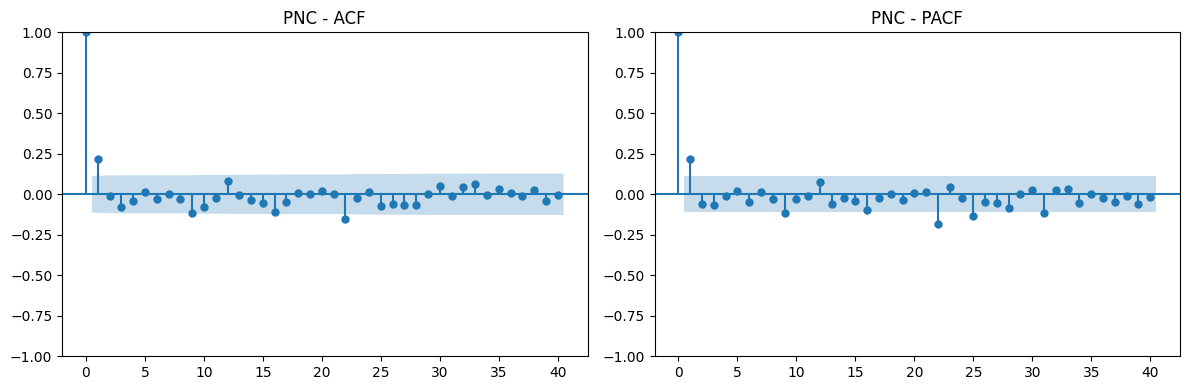

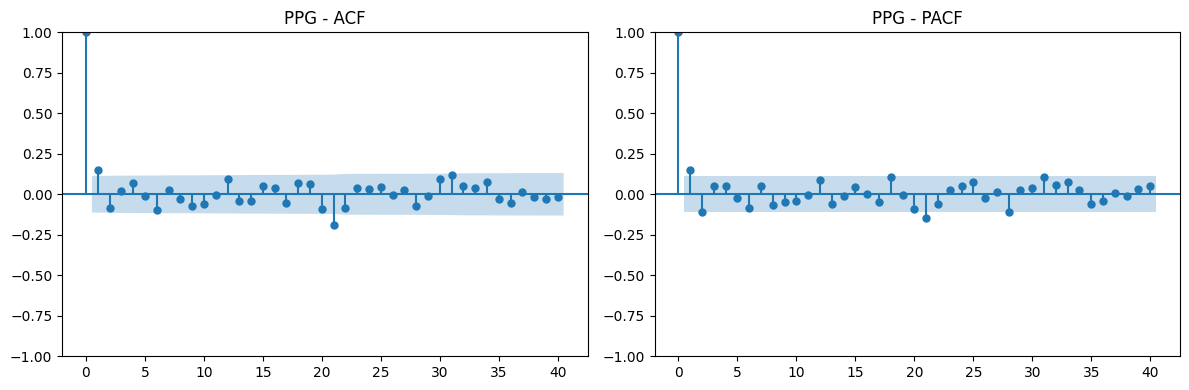

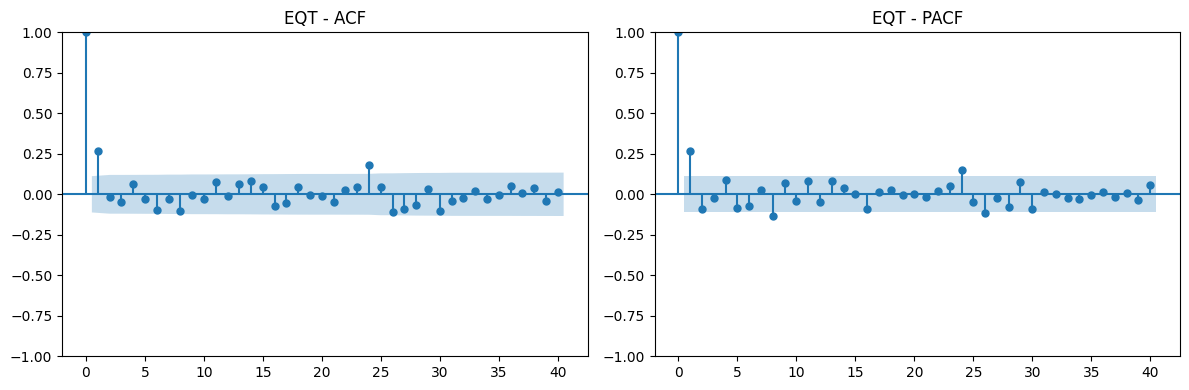

In [4]:
tickers = ['PNC', 'PPG', 'EQT']

for ticker in tickers:
    series = processed_data[ticker]

    fig, axis = plt.subplots(1,2,figsize = (12,4))

    sgt.plot_acf(series, lags = 40, ax = axis[0])
    axis[0].set_title(f"{ticker} - ACF")

    sgt.plot_pacf(series, lags = 40, ax=axis[1], method='ywm')
    axis[1].set_title(f"{ticker} - PACF")

    plt.tight_layout()
    plt.show()

Looking at the ACF and PACF of each of the stocks, we generally find that only the first lag is statistically significant for both PNC and EQT. The PPG stock seems to indicate that the second lag variable is slightly significant. Each of the stocks has statistically significant values past 20 or so lag variables, but they are not uniform in time steps. Let's proceed with a (1,0,0) model for the PNC and EQT data, and a (2,0,0) model for the PPG data. Recall that the percentage change was already drawn from a stationary process, so differencing here is not required. 

### PNC ARIMA

c:\Users\benns\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\benns\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\benns\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    PNC   No. Observations:                  294
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -964.851
Date:                Wed, 03 Sep 2025   AIC                           1935.703
Time:                        17:12:35   BIC                           1946.753
Sample:                    02-01-2000   HQIC                          1940.128
                         - 07-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9440      0.507      1.860      0.063      -0.050       1.939
ar.L1          0.2189      0.053      4.137      0.000       0.115       0.323
sigma2        41.4947      1.632     25.422      0.0

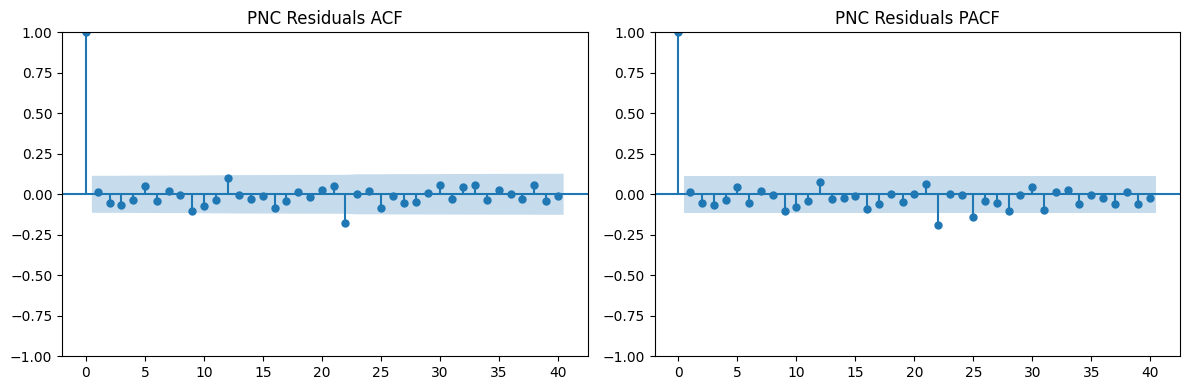


RMSE: 6.6788
Max Absolute Error: 10.7828


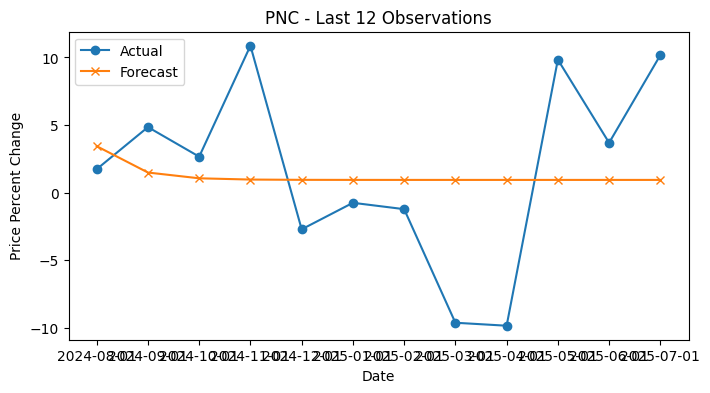

In [15]:
series = processed_data['PNC']

train = series.iloc[:-12]
test = series.iloc[-12:]

pnc_arima = ARIMA(train, order = (1,0,0))
pnc_arima_fit = pnc_arima.fit()

print(pnc_arima_fit.summary())

pnc_arima_resid = pnc_arima_fit.resid

fig, axis = plt.subplots(1,2, figsize = (12,4))
sgt.plot_acf(pnc_arima_resid, lags = 40, ax = axis[0])
axis[0].set_title("PNC Residuals ACF")

sgt.plot_pacf(pnc_arima_resid, lags = 40, ax = axis[1], method = 'ywm')
axis[1].set_title("PNC Residuals PACF")

plt.tight_layout()
plt.show()

pnc_arima_forecast = pnc_arima_fit.forecast(steps = 12)

pnc_arima_rmse = np.sqrt(mean_squared_error(test, pnc_arima_forecast))
pnc_arima_mae = max_error(test, pnc_arima_forecast)

print(f"\nRMSE: {pnc_arima_rmse:.4f}")
print(f"Max Absolute Error: {pnc_arima_mae:.4f}")

plt.figure(figsize = (8,4))
plt.plot(test.index, test.values, label = 'Actual', marker = 'o')
plt.plot(test.index, pnc_arima_forecast, label = 'Forecast', marker = 'x')
plt.title("PNC - Last 12 Observations")
plt.xlabel("Date")
plt.ylabel('Price Percent Change')
plt.legend()
plt.show()

After fitting our model, we see that the ACF and PACF of the residuals resemble mostly noise. 

The only AR term in the model is statistically significant and our model has an AIC of 1935.70.

The predicted values of the stock fails to capture the trend of the actual price differences. Let's hope introducing seasonality remedies this.

The including an AR term in the model has removed the statistical significance of the lag term in the ACF and PACF. There are still statistically significant terms occuring for later lag values, but this is a start. The model forecast converges quickly to a nonzero constant of .94 which is expected of a (1,0,0) process and we obtain an RMSE of 6.6788 and Max Absolute Error of 10.7828.

One may suspect a more complex ARIMA model to perform better. We could check larger values of p,d,q below to see if changes in the parameters produces a better fit or reduced errors. Increasing any parameter by one results in only slight deviations of our metrics and increases the AIC. This indicates a (1,0,0) process is the most likely model of this type to produce a good fit. One may confirm this with a Log Likelihood ratio test.

### PPG ARIMA

c:\Users\benns\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\benns\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\benns\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    PPG   No. Observations:                  294
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -930.756
Date:                Wed, 03 Sep 2025   AIC                           1869.512
Time:                        17:13:21   BIC                           1884.246
Sample:                    02-01-2000   HQIC                          1875.412
                         - 07-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8715      0.383      2.278      0.023       0.122       1.621
ar.L1          0.1782      0.068      2.633      0.008       0.046       0.311
ar.L2         -0.1245      0.059     -2.115      0.0

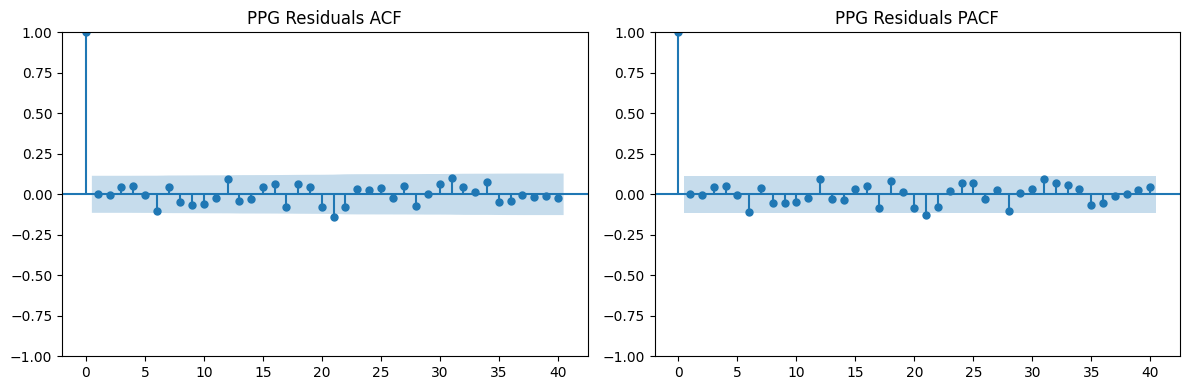


RMSE: 4.7629
Max Absolute Error: 10.0517


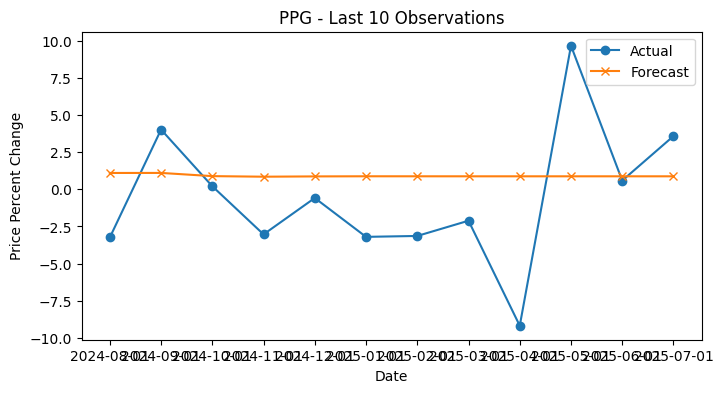

In [16]:
series = processed_data['PPG']

train = series.iloc[:-12]
test = series.iloc[-12:]

ppg_arima = ARIMA(train, order = (2,0,0))
ppg_arima_fit = ppg_arima.fit()

print(ppg_arima_fit.summary())

ppg_arima_resid = ppg_arima_fit.resid

fig, axis = plt.subplots(1,2, figsize = (12,4))
sgt.plot_acf(ppg_arima_resid, lags = 40, ax = axis[0])
axis[0].set_title("PPG Residuals ACF")

sgt.plot_pacf(ppg_arima_resid, lags = 40, ax = axis[1], method = 'ywm')
axis[1].set_title("PPG Residuals PACF")

plt.tight_layout()
plt.show()

ppg_arima_forecast = ppg_arima_fit.forecast(steps = 12)

ppg_arima_rmse = np.sqrt(mean_squared_error(test, ppg_arima_forecast))
ppg_arima_mae = max_error(test, ppg_arima_forecast)

print(f"\nRMSE: {ppg_arima_rmse:.4f}")
print(f"Max Absolute Error: {ppg_arima_mae:.4f}")

plt.figure(figsize = (8,4))
plt.plot(test.index, test.values, label = 'Actual', marker = 'o')
plt.plot(test.index, ppg_arima_forecast, label = 'Forecast', marker = 'x')
plt.title("PPG - Last 10 Observations")
plt.xlabel("Date")
plt.ylabel('Price Percent Change')
plt.legend()
plt.show()

For the PPG stock, the (2,0,0) model has performed better in both metrics than the (1,0,0) for the PNC stock.

Both AR terms in the model are statistically significant and our model has an AIC of 1869.51.

Again, we fail to capture the trend of the series and the predictions rapidly converge to the constant value of the model.

The ACF and PACF again resemble noise.

### EQT ARIMA

c:\Users\benns\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\benns\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\benns\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    EQT   No. Observations:                  294
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1053.940
Date:                Wed, 03 Sep 2025   AIC                           2113.880
Time:                        17:14:00   BIC                           2124.930
Sample:                    02-01-2000   HQIC                          2118.305
                         - 07-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1757      0.772      1.523      0.128      -0.337       2.689
ar.L1          0.2630      0.031      8.406      0.000       0.202       0.324
sigma2        76.0614      3.378     22.519      0.0

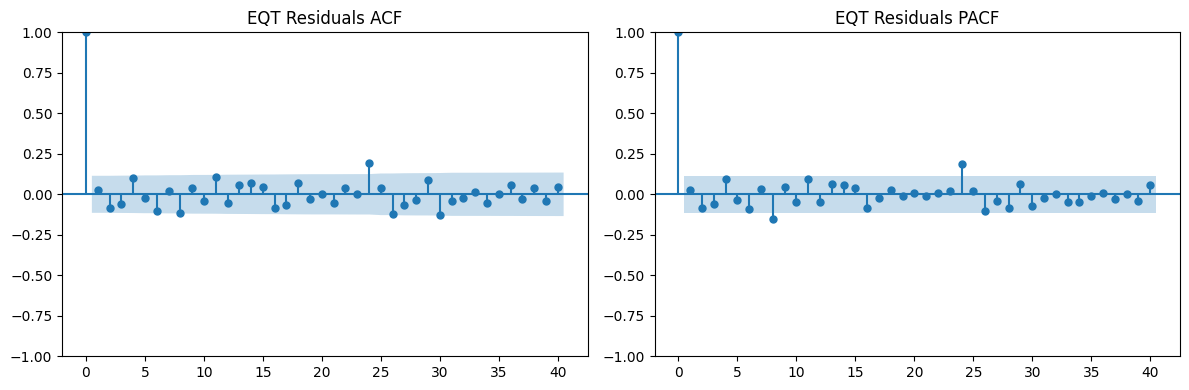


RMSE: 7.6385
Max Absolute Error: 15.7002


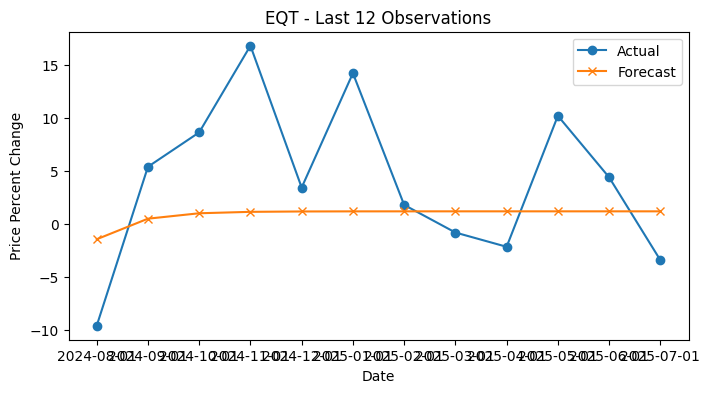

In [17]:
series = processed_data['EQT']

train = series.iloc[:-12]
test = series.iloc[-12:]

eqt_arima = ARIMA(train, order = (1,0,0))
eqt_arima_fit = eqt_arima.fit()

print(eqt_arima_fit.summary())

eqt_arima_resid = eqt_arima_fit.resid

fig, axis = plt.subplots(1,2, figsize = (12,4))
sgt.plot_acf(eqt_arima_resid, lags = 40, ax = axis[0])
axis[0].set_title("EQT Residuals ACF")

sgt.plot_pacf(eqt_arima_resid, lags = 40, ax = axis[1], method = 'ywm')
axis[1].set_title("EQT Residuals PACF")

plt.tight_layout()
plt.show()

eqt_arima_forecast = eqt_arima_fit.forecast(steps = 12)

eqt_arima_rmse = np.sqrt(mean_squared_error(test, eqt_arima_forecast))
eqt_arima_mae = max_error(test, eqt_arima_forecast)

print(f"\nRMSE: {eqt_arima_rmse:.4f}")
print(f"Max Absolute Error: {eqt_arima_mae:.4f}")

plt.figure(figsize = (8,4))
plt.plot(test.index, test.values, label = 'Actual', marker = 'o')
plt.plot(test.index, eqt_arima_forecast, label = 'Forecast', marker = 'x')
plt.title("EQT - Last 12 Observations")
plt.xlabel("Date")
plt.ylabel('Price Percent Change')
plt.legend()
plt.show()

The base ARIMA model here performs similarly to the other two. We obtain a stabilizing forecast that fails to capture the trend of the percentage prices.

Let's move onto a Seasonal model for each stock price without exogenous variables. We will utilize the base ARIMA parameters computed above and utilize the ACF and PACF residuals for the seasonal decomposition of each stock price to determine the (P,D,Q,S) parameters for each.

The exogenous variables we use, unemployment and housing prices exhibit a clear seasonality in the data of a 12 month period. We will utilize the same period for each of our seasonal models.

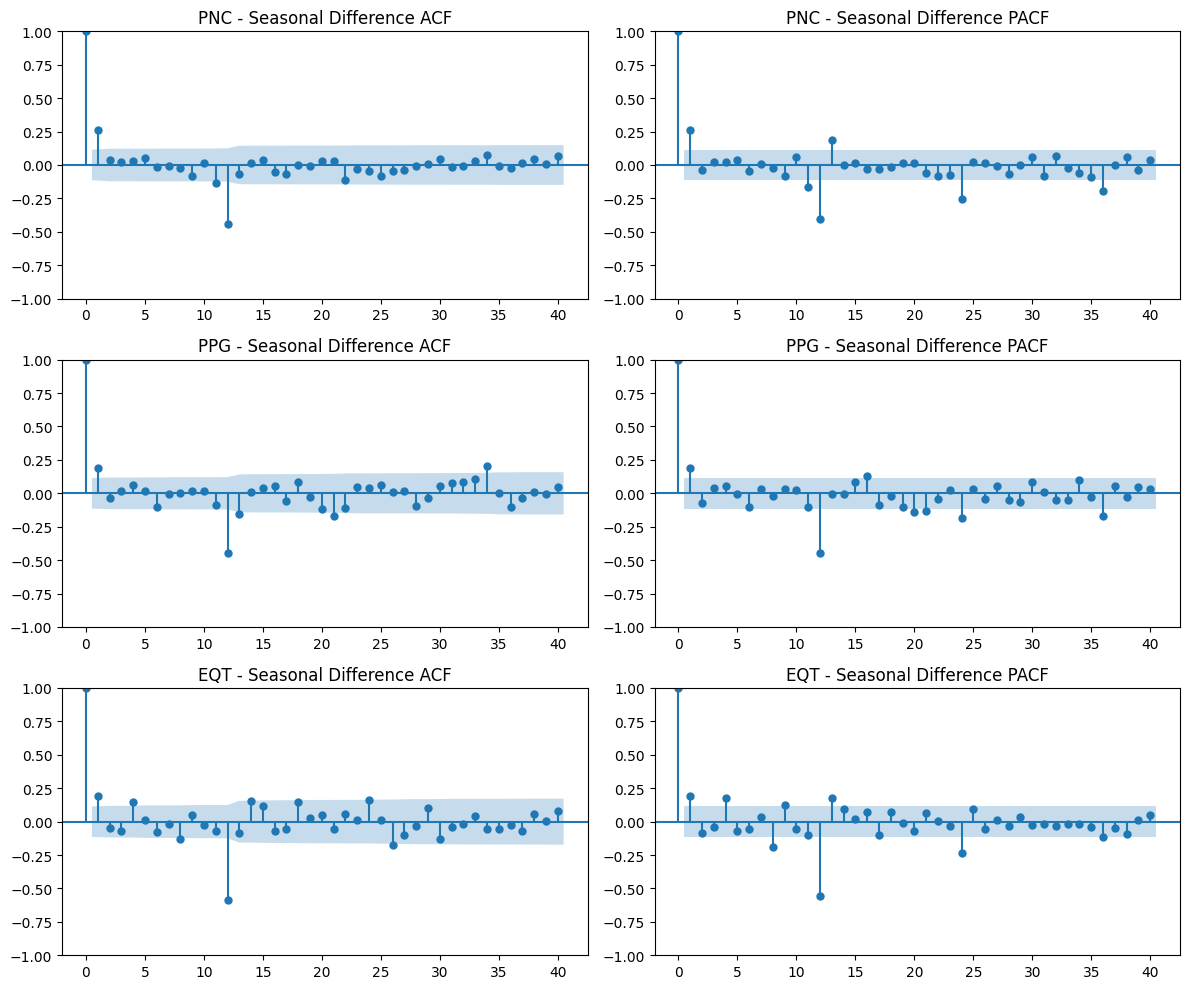

In [8]:
fig, axis = plt.subplots(len(tickers), 2, figsize = (12,10))

for i, ticker in enumerate(tickers):
    series =processed_data[ticker]

    diff_series = series.diff(12).dropna()

    sgt.plot_acf(diff_series, lags = 40, ax = axis[i,0])
    axis[i,0].set_title(f"{ticker} - Seasonal Difference ACF")

    sgt.plot_pacf(diff_series, lags = 40, ax = axis[i,1], method = 'ywm')
    axis[i,1].set_title(f"{ticker} - Seasonal Difference PACF")

plt.tight_layout()
plt.show()

From the seasonally differenced data, we see that the first variable remains statistically significant. We also see large spikes of significant for multiples of 12, although because this pattern was not present in the original ACF and PACF plots it is likley induced from the differencing. Let's fit a seasonal SARIMAX model to each of the stock prices to see if performance improves.

### PNC SARIMA

c:\Users\benns\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\benns\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                                PNC   No. Observations:                  294
Model:             SARIMAX(1, 0, 0)x(3, 1, 0, 12)   Log Likelihood                -954.129
Date:                            Wed, 03 Sep 2025   AIC                           1918.257
Time:                                    17:16:47   BIC                           1936.467
Sample:                                02-01-2000   HQIC                          1925.559
                                     - 07-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2326      0.065      3.593      0.000       0.106       0.359
ar.S.L12      -0.6699      0.054   

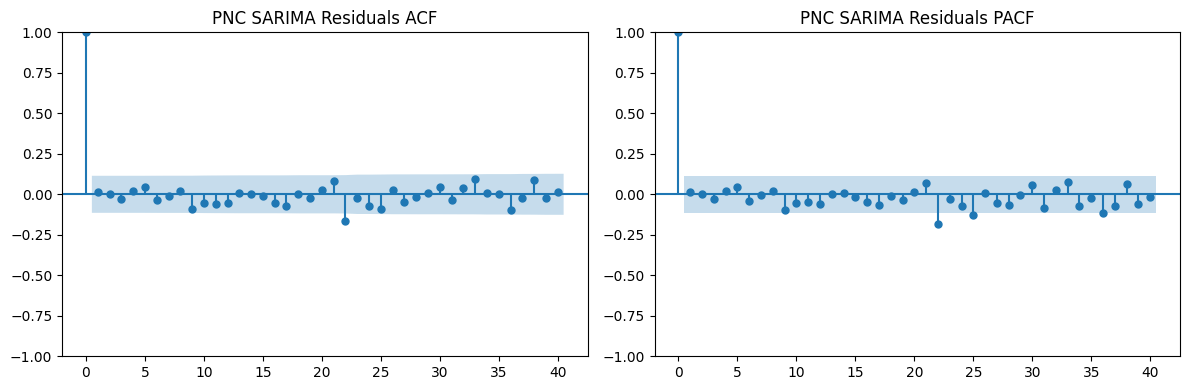


RMSE: 6.3673
Max Absolute Error: 10.6739


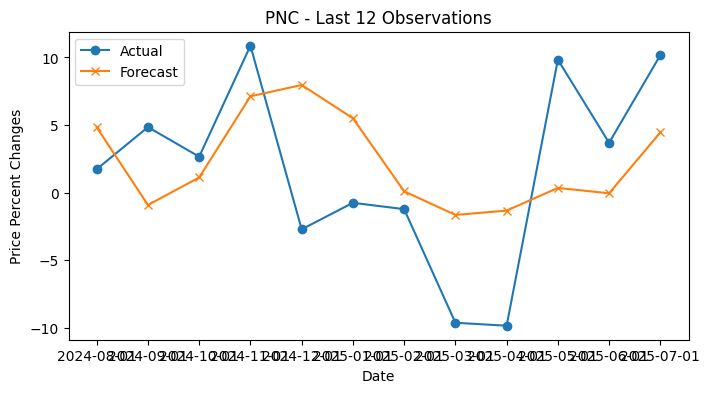

In [18]:
series = processed_data['PNC']

train = series.iloc[:-12]
test = series.iloc[-12:]

pnc_sarima = SARIMAX(train, order = (1,0,0), seasonal_order=(3,1,0,12))
pnc_sarima_fit = pnc_sarima.fit()

print(pnc_sarima_fit.summary())

pnc_sarima_resid = pnc_sarima_fit.resid

fig, axis = plt.subplots(1,2, figsize = (12,4))
sgt.plot_acf(pnc_sarima_resid, lags = 40, ax = axis[0])
axis[0].set_title("PNC SARIMA Residuals ACF")

sgt.plot_pacf(pnc_sarima_resid, lags = 40, ax = axis[1], method = 'ywm')
axis[1].set_title("PNC SARIMA Residuals PACF")

plt.tight_layout()
plt.show()

pnc_sarima_forecast = pnc_sarima_fit.forecast(steps = 12)

pnc_sarima_rmse = np.sqrt(mean_squared_error(test, pnc_sarima_forecast))
pnc_sarima_mae = max_error(test, pnc_sarima_forecast)

print(f"\nRMSE: {pnc_sarima_rmse:.4f}")
print(f"Max Absolute Error: {pnc_sarima_mae:.4f}")

plt.figure(figsize = (8,4))
plt.plot(test.index, test.values, label = 'Actual', marker = 'o')
plt.plot(test.index, pnc_sarima_forecast, label = 'Forecast', marker = 'x')
plt.title("PNC - Last 12 Observations")
plt.xlabel("Date")
plt.ylabel('Price Percent Changes')
plt.legend()
plt.show()

Seasonal parameters of (3,1,0,12) generated the best fit for our data although the ACF/PACF do not indicate this. All three seasonal lags have statistical significanece in the model. We can see that in general the model seems to capture a non-stationary trend, and generally does capture the direction of the percent changes but fails to account for the magnitude. The model is learning the behavior however, as both target metrics decrease. We also have a lower AIC score for the model and the ACF/PACF resembles noise at this point.

### PPG SARIMA

c:\Users\benns\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\benns\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                                PPG   No. Observations:                  294
Model:             SARIMAX(2, 0, 0)x(4, 1, 0, 12)   Log Likelihood                -919.528
Date:                            Wed, 03 Sep 2025   AIC                           1853.057
Time:                                    17:18:18   BIC                           1878.550
Sample:                                02-01-2000   HQIC                          1863.280
                                     - 07-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1891      0.075      2.535      0.011       0.043       0.335
ar.L2         -0.0617      0.058   

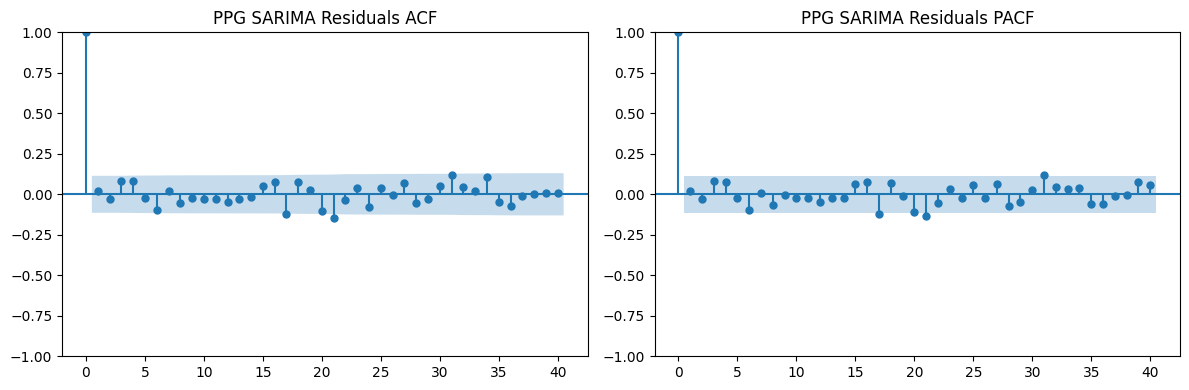


RMSE: 5.9812
Max Absolute Error: 12.7273


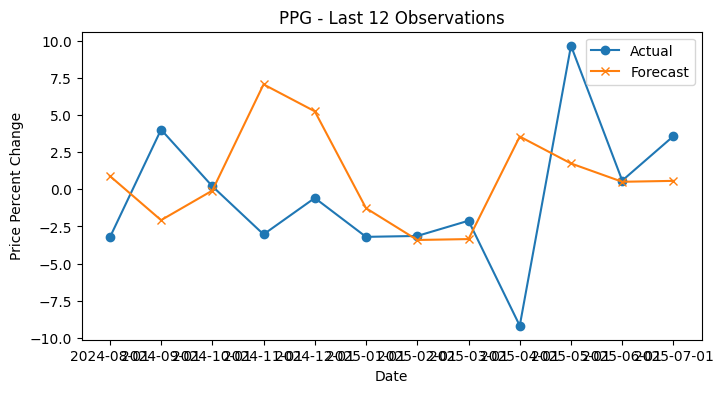

In [21]:
series = processed_data['PPG']

train = series.iloc[:-12]
test = series.iloc[-12:]

ppg_sarima = SARIMAX(train, order = (2,0,0), seasonal_order=(4,1,0,12))
ppg_sarima_fit = ppg_sarima.fit()

print(ppg_sarima_fit.summary())

ppg_sarima_resid = ppg_sarima_fit.resid

fig, axis = plt.subplots(1,2, figsize = (12,4))
sgt.plot_acf(ppg_sarima_resid, lags = 40, ax = axis[0])
axis[0].set_title("PPG SARIMA Residuals ACF")

sgt.plot_pacf(ppg_sarima_resid, lags = 40, ax = axis[1], method = 'ywm')
axis[1].set_title("PPG SARIMA Residuals PACF")

plt.tight_layout()
plt.show()

ppg_sarima_forecast = ppg_sarima_fit.forecast(steps = 12)

ppg_sarima_rmse = np.sqrt(mean_squared_error(test, ppg_sarima_forecast))
ppg_sarima_mae = max_error(test, ppg_sarima_forecast)

print(f"\nRMSE: {ppg_sarima_rmse:.4f}")
print(f"Max Absolute Error: {ppg_sarima_mae:.4f}")

plt.figure(figsize = (8,4))
plt.plot(test.index, test.values, label = 'Actual', marker = 'o')
plt.plot(test.index, ppg_sarima_forecast, label = 'Forecast', marker = 'x')
plt.title("PPG - Last 12 Observations")
plt.xlabel("Date")
plt.ylabel('Price Percent Change')
plt.legend()
plt.show()

The addition of a seasonal component with PPG seemed to hurt model performance. There are a couple of excellent predicted values, but the model fails to capture the general trend of the returns and model performance decreased with respect to both metrics. 


### EQT SARIMA

c:\Users\benns\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\benns\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                                EQT   No. Observations:                  294
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 12)   Log Likelihood               -1034.934
Date:                            Wed, 03 Sep 2025   AIC                           2077.868
Time:                                    17:18:33   BIC                           2092.436
Sample:                                02-01-2000   HQIC                          2083.710
                                     - 07-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2737      0.039      7.073      0.000       0.198       0.349
ar.S.L12      -0.8280      0.052   

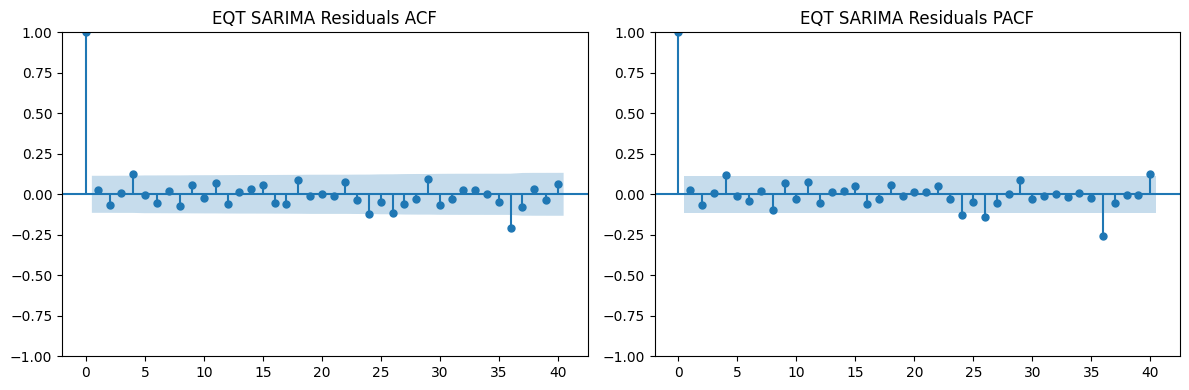


RMSE: 11.4688
Max Absolute Error: 19.5740


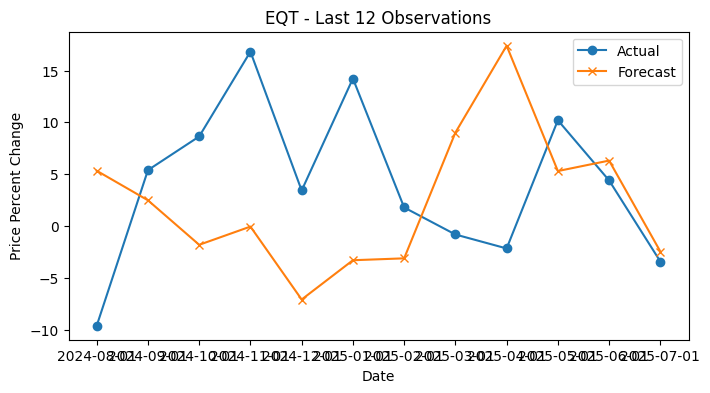

In [22]:
series = processed_data['EQT']

train = series.iloc[:-12]
test = series.iloc[-12:]

eqt_sarima = SARIMAX(train, order = (1,0,0), seasonal_order=(2,1,0,12))
eqt_sarima_fit = eqt_sarima.fit()

print(eqt_sarima_fit.summary())

eqt_sarima_resid = eqt_sarima_fit.resid

fig, axis = plt.subplots(1,2, figsize = (12,4))
sgt.plot_acf(eqt_sarima_resid, lags = 40, ax = axis[0])
axis[0].set_title("EQT SARIMA Residuals ACF")

sgt.plot_pacf(eqt_sarima_resid, lags = 40, ax = axis[1], method = 'ywm')
axis[1].set_title("EQT SARIMA Residuals PACF")

plt.tight_layout()
plt.show()

eqt_sarima_forecast = eqt_sarima_fit.forecast(steps = 12)

eqt_sarima_rmse = np.sqrt(mean_squared_error(test, eqt_sarima_forecast))
eqt_sarima_mae = max_error(test, eqt_sarima_forecast)

print(f"\nRMSE: {eqt_sarima_rmse:.4f}")
print(f"Max Absolute Error: {eqt_sarima_mae:.4f}")

plt.figure(figsize = (8,4))
plt.plot(test.index, test.values, label = 'Actual', marker = 'o')
plt.plot(test.index, eqt_sarima_forecast, label = 'Forecast', marker = 'x')
plt.title("EQT - Last 12 Observations")
plt.xlabel("Date")
plt.ylabel('Price Percent Change')
plt.legend()
plt.show()

Here the seasonal model underperforms as well. We see that the model fails to capture the trend and metrics worsen across the board.

Our last SARIMAX model family will incorperate our local economic exogenous variables to attempt to improve model accuracy. We will include the percentage changes of unemplyoment rate, median home prices and unemployment.

### PNC SARIMAX

c:\Users\benns\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\benns\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                                PNC   No. Observations:                  294
Model:             SARIMAX(1, 0, 0)x(3, 1, 0, 12)   Log Likelihood                -953.794
Date:                            Wed, 03 Sep 2025   AIC                           1921.588
Time:                                    17:19:23   BIC                           1947.082
Sample:                                02-01-2000   HQIC                          1931.811
                                     - 07-01-2024                                         
Covariance Type:                              opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Unemployment    -0.0235      0.028     -0.851      0.395      -0.078       0.031
Med Home         0.2496      

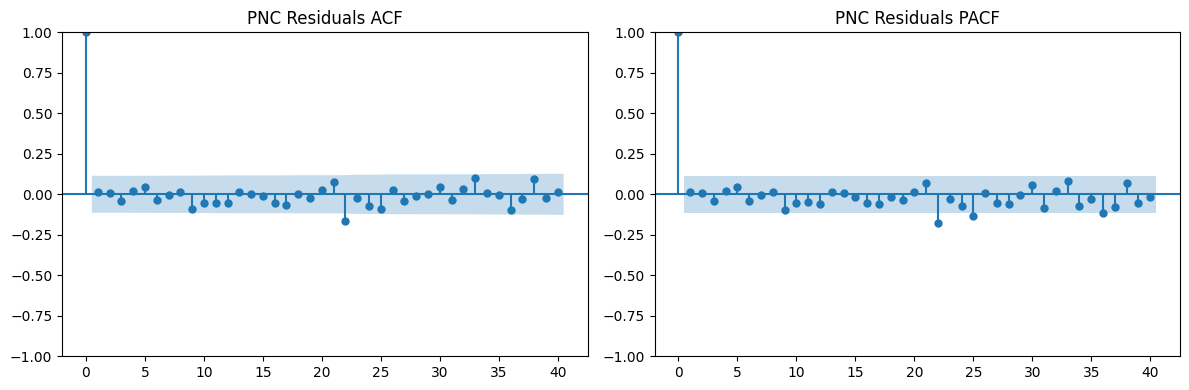


RMSE: 6.3249
Max Absolute Error: 10.8575


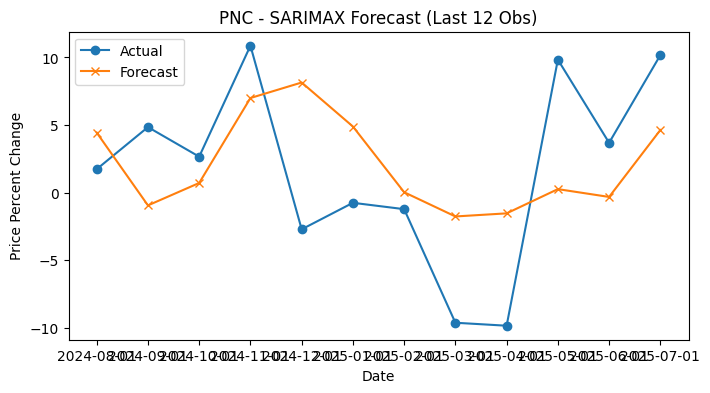

In [23]:
target = 'PNC'
exog_vars = ['Unemployment', 'Med Home']

series = processed_data[target]
exog = processed_data[exog_vars]

train_end = -12
train_y, test_y = series.iloc[:train_end], series.iloc[train_end:]
train_exog, test_exog = exog.iloc[:train_end], exog.iloc[train_end:]

model = SARIMAX(train_y, exog=train_exog, order=(1,0,0), seasonal_order=(3,1,0,12))
fit = model.fit()

print(fit.summary())

residuals = fit.resid

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sgt.plot_acf(residuals, lags=40, ax=axes[0])
axes[0].set_title(f"{target} Residuals ACF")

sgt.plot_pacf(residuals, lags=40, ax=axes[1], method='ywm')
axes[1].set_title(f"{target} Residuals PACF")

plt.tight_layout()
plt.show()

forecast = fit.forecast(steps=12, exog=test_exog)

rmse = np.sqrt(mean_squared_error(test_y, forecast))
mae = max_error(test_y, forecast)

print(f"\nRMSE: {rmse:.4f}")
print(f"Max Absolute Error: {mae:.4f}")

plt.figure(figsize=(8, 4))
plt.plot(test_y.index, test_y.values, label="Actual", marker='o')
plt.plot(test_y.index, forecast.values, label="Forecast", marker='x')
plt.title(f"{target} - SARIMAX Forecast (Last 12 Obs)")
plt.xlabel("Date")
plt.ylabel("Price Percent Change")
plt.legend()
plt.show()

Modeling with both Unemployment and Median Home value provided the lowest RMSE with a value of 6.3249 out of the Exogenous variable combinations. This model also outperformed the basic ARIMA and SARIMA models with optimal parameter choices. 

### PPG SARIMAX

c:\Users\benns\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\benns\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                                PPG   No. Observations:                  294
Model:             SARIMAX(2, 0, 0)x(4, 1, 0, 12)   Log Likelihood                -919.128
Date:                            Wed, 03 Sep 2025   AIC                           1854.256
Time:                                    17:20:35   BIC                           1883.391
Sample:                                02-01-2000   HQIC                          1865.940
                                     - 07-01-2024                                         
Covariance Type:                              opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Unemployment    -0.0243      0.027     -0.903      0.367      -0.077       0.028
ar.L1            0.1743      

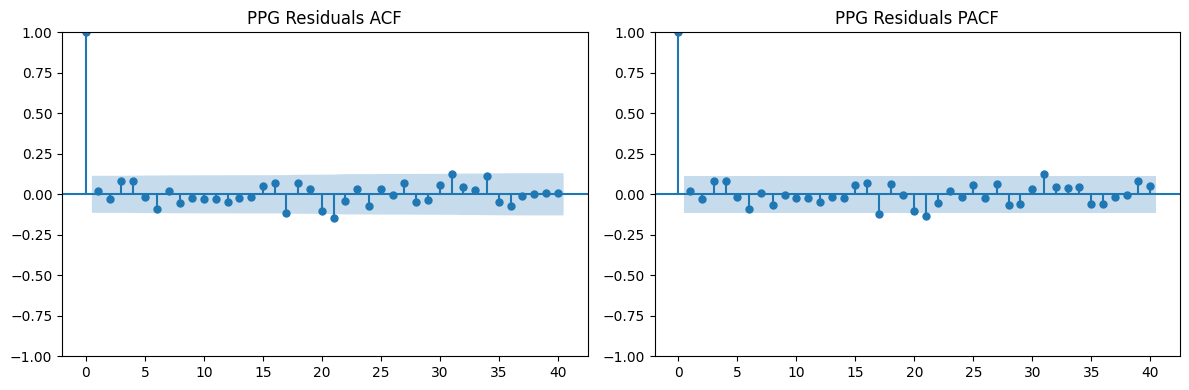


RMSE: 6.0651
Max Absolute Error: 13.2337


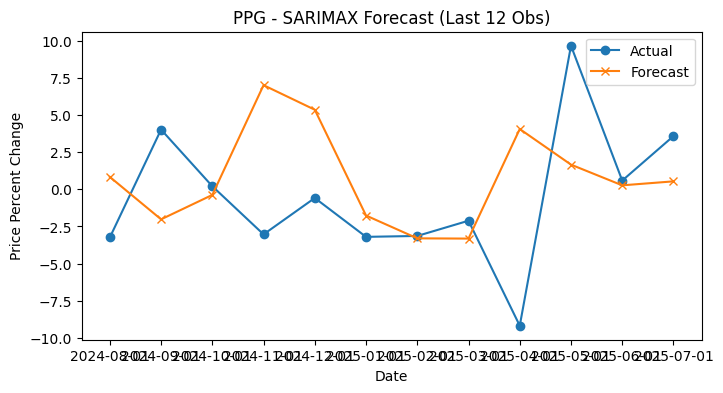

In [25]:
target = 'PPG'
exog_vars = ['Unemployment']

series = processed_data[target]
exog = processed_data[exog_vars]

train_end = -12
train_y, test_y = series.iloc[:train_end], series.iloc[train_end:]
train_exog, test_exog = exog.iloc[:train_end], exog.iloc[train_end:]

model = SARIMAX(train_y, exog=train_exog, order=(2,0,0), seasonal_order=(4,1,0,12))
fit = model.fit()

print(fit.summary())

residuals = fit.resid

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sgt.plot_acf(residuals, lags=40, ax=axes[0])
axes[0].set_title(f"{target} Residuals ACF")

sgt.plot_pacf(residuals, lags=40, ax=axes[1], method='ywm')
axes[1].set_title(f"{target} Residuals PACF")

plt.tight_layout()
plt.show()

forecast = fit.forecast(steps=12, exog=test_exog)

rmse = np.sqrt(mean_squared_error(test_y, forecast))
mae = max_error(test_y, forecast)

print(f"\nRMSE: {rmse:.4f}")
print(f"Max Absolute Error: {mae:.4f}")

plt.figure(figsize=(8, 4))
plt.plot(test_y.index, test_y.values, label="Actual", marker='o')
plt.plot(test_y.index, forecast.values, label="Forecast", marker='x')
plt.title(f"{target} - SARIMAX Forecast (Last 12 Obs)")
plt.xlabel("Date")
plt.ylabel("Price Percent Change")
plt.legend()
plt.show()

Utilizing the same SARIMAX parameters as before seemed to worsen model performance when considering Exogenous variables. 

c:\Users\benns\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\benns\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                                EQT   No. Observations:                  294
Model:             SARIMAX(1, 0, 0)x(3, 1, 0, 12)   Log Likelihood               -1017.875
Date:                            Wed, 03 Sep 2025   AIC                           2049.751
Time:                                    17:21:52   BIC                           2075.244
Sample:                                02-01-2000   HQIC                          2059.974
                                     - 07-01-2024                                         
Covariance Type:                              opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Unemployment     0.2024      0.018     11.384      0.000       0.168       0.237
Med Home         0.8049      

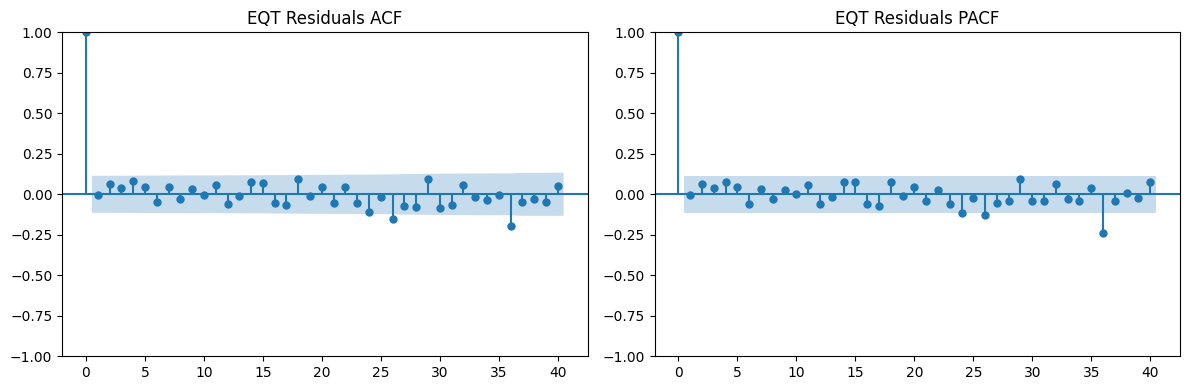


RMSE: 10.7346
Max Absolute Error: 19.5835


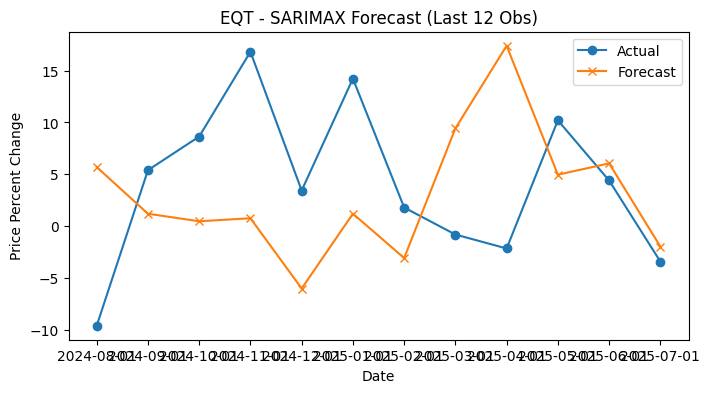

In [26]:
target = 'EQT'
exog_vars = ['Unemployment', 'Med Home']

series = processed_data[target]
exog = processed_data[exog_vars]

train_end = -12
train_y, test_y = series.iloc[:train_end], series.iloc[train_end:]
train_exog, test_exog = exog.iloc[:train_end], exog.iloc[train_end:]

model = SARIMAX(train_y, exog=train_exog, order=(1,0,0), seasonal_order=(3,1,0,12))
fit = model.fit()

print(fit.summary())

residuals = fit.resid

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sgt.plot_acf(residuals, lags=40, ax=axes[0])
axes[0].set_title(f"{target} Residuals ACF")

sgt.plot_pacf(residuals, lags=40, ax=axes[1], method='ywm')
axes[1].set_title(f"{target} Residuals PACF")

plt.tight_layout()
plt.show()

forecast = fit.forecast(steps=12, exog=test_exog)

rmse = np.sqrt(mean_squared_error(test_y, forecast))
mae = max_error(test_y, forecast)

print(f"\nRMSE: {rmse:.4f}")
print(f"Max Absolute Error: {mae:.4f}")

plt.figure(figsize=(8, 4))
plt.plot(test_y.index, test_y.values, label="Actual", marker='o')
plt.plot(test_y.index, forecast.values, label="Forecast", marker='x')
plt.title(f"{target} - SARIMAX Forecast (Last 12 Obs)")
plt.xlabel("Date")
plt.ylabel("Price Percent Change")
plt.legend()
plt.show()

We obtain slightly better results than the base SARIMA model, but still far off from the performance of the trivial forecasting done by the ARIMA model.

The scores of each of the models are in the table below.

| RMSE / MAE | Best ARIMA | Best SARIMA | Best SARIMAX|
|------------|------------|-------------|-------------|
|PNC| 6.6788 / 10.7828 | 6.3673 / 10.6739 | 6.3249 / 10.8575|
|PPG| 4.7629 / 10.0517 | 5.9812 / 12.7223 | 6.0651 / 13.2337|
|EQT| 7.6385 / 15.7002 | 11.4688 / 19.5740 | 10.7346 / 19.5638|

## Summary of Model Performance

Looking at each of the stocks, it seems that each exhibits different behavior with respect to model selection. 

For PNC, increased model complexity slightly improved performance. We have a negligible difference between all three models. One might say from the slight improvement that PNC stock does exhibit some seasonal behavior. Modeling with our local variables improved RMSE but worsened MAE by a larger magnitude. 

PPG suffered in performance with increased model complexity. It is likley that PPG stock percentage changes exhibit no yearly seasonal pattern, and the association between these stock return percentages and local economic data is weak.

EQT suffered greatly with increased model complexity. Like PPG, imposing a seasonal pattern on the stock data seems to worsen predictions substantially, although our local variables did improve performance from there.

In summary, it is unlikely that stock percentage returns follow the same seasonal patterns as our local economic variables and more unlikely that our local economic data is reflected in the stock market changes. This is not entirely unexpected since the stock market is a global network. Other metrics of financial viability instead of stock prices may be used as a proxy for business success, but as businesses expand, so too does their economic profile across America and the world. 
